In [42]:
from maze_solver import *
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from neural_network_class import NeuralNetwork


## 2.1) ENTRENAMIENTO DE LA RED NEURONAL

 - Green (grama) -> Weight: 2
 - Yellow (arena) -> Weight: 3
 - Blue (agua) -> Weight: 9
 - Grey (pavimento) -> Weight: 1
 - Pink (chicle) -> Weight: 10

In [43]:
df = pd.read_csv("data/final_data_colors.csv")

print(f"Primeras 10 filas:\n{df.head(10)}")
print(f"Tipos de datos:\n{df.dtypes}")
print(f"Etiquetas únicas:\n{df['label'].unique()}")
print(f"Conteo por etiqueta:\n{df['label'].value_counts()}")
print(f"Dimensiones:\n{df.shape}")
print(f"Tipos de datos por columna:\n{df.info()}")


Primeras 10 filas:
   red  green  blue   label
0   20    139   240    Blue
1  174     83    72   Brown
2  144    249   131   Green
3  168     25   156    Pink
4   30    182   136   Green
5  199    150   175    Pink
6  199     93   154    Pink
7  231    243    25  Yellow
8   48    213    76   Green
9   38      3    64    Blue
Tipos de datos:
red      int64
green    int64
blue     int64
label      str
dtype: object
Etiquetas únicas:
<StringArray>
[  'Blue',  'Brown',  'Green',   'Pink', 'Yellow', 'Orange', 'Purple',
    'Red',   'Grey',  'White',  'Black']
Length: 11, dtype: str
Conteo por etiqueta:
label
Green     1457
Blue      1107
Pink       579
Purple     553
Brown      376
Yellow     285
Red        236
Orange     205
Grey       174
Black       51
White       29
Name: count, dtype: int64
Dimensiones:
(5052, 4)
<class 'pandas.DataFrame'>
RangeIndex: 5052 entries, 0 to 5051
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   red  

In [44]:
df_filtered = df[df["label"].isin(["Green", "Yellow", "Blue", "Grey", "Pink"])]

lb = LabelBinarizer()

# esto lo que hace es convertir las etiquetas de texto a números binarios, por ejemplo:
# Green -> [1, 0, 0, 0, 0]
Y = lb.fit_transform(df_filtered["label"])

print(f"Y shape: {Y.shape}")
print(f"Y sample: {Y[0]}") # type: ignore

X = df_filtered[["red", "green", "blue"]].values
X = X / 255.0
print(f"X shape: {X.shape}")
print(f"X min: {X.min()}, X max: {X.max()}")


Y shape: (3602, 5)
Y sample: [1 0 0 0 0]
X shape: (3602, 3)
X min: 0.0, X max: 0.996078431372549


In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

print("Distribucion del train:")
for i, label in enumerate(lb.classes_):
    count = Y_train[:, i].sum()
    print(f"Label {label}: {count} samples")

X_train shape: (2881, 3), Y_train shape: (2881, 5)
X_test shape: (721, 3), Y_test shape: (721, 5)
Distribucion del train:
Label Blue: 877 samples
Label Green: 1166 samples
Label Grey: 134 samples
Label Pink: 468 samples
Label Yellow: 236 samples


In [46]:


# Instanciar la red neuronal con arquitectura: 3 → 32 → 16 → 5
nn = NeuralNetwork(layer_sizes=[3, 32, 16, 5])

# Entrenar la red neuronal
print("Iniciando entrenamiento...")
losses = nn.train(X_train, Y_train, epochs=400, learning_rate=0.1, batch_size=32)
print(f"Entrenamiento completado.")


Iniciando entrenamiento...
Entrenamiento completado. Loss final: 0.1267
Entrenamiento completado.


In [47]:
# EVALUACIÓN EN TEST SET
# Hacer predicciones en el conjunto de prueba
Y_test_pred, _ = nn.forward(X_test)
predictions = nn.predict(X_test)

# Convertir Y_test one-hot a índices de clases
y_test_true = np.argmax(Y_test, axis=1)

# Calcular accuracy
accuracy = nn.accuracy(predictions, y_test_true)

print(f"\n=== RESULTADOS ===")
print(f"Accuracy en Test Set: {accuracy:.2f}%")
print(f"\nPredicciones (primeras 10):")
for i in range(10):
    pred_class = lb.classes_[predictions[i]]
    true_class = lb.classes_[y_test_true[i]]
    match = "✓" if predictions[i] == y_test_true[i] else "✗"
    print(f"  Sample {i}: Predicción={pred_class}, Real={true_class} {match}")



=== RESULTADOS ===
Accuracy en Test Set: 91.96%

Predicciones (primeras 10):
  Sample 0: Predicción=Blue, Real=Blue ✓
  Sample 1: Predicción=Yellow, Real=Green ✗
  Sample 2: Predicción=Green, Real=Green ✓
  Sample 3: Predicción=Yellow, Real=Yellow ✓
  Sample 4: Predicción=Blue, Real=Blue ✓
  Sample 5: Predicción=Grey, Real=Green ✗
  Sample 6: Predicción=Green, Real=Green ✓
  Sample 7: Predicción=Blue, Real=Blue ✓
  Sample 8: Predicción=Green, Real=Green ✓
  Sample 9: Predicción=Blue, Real=Blue ✓


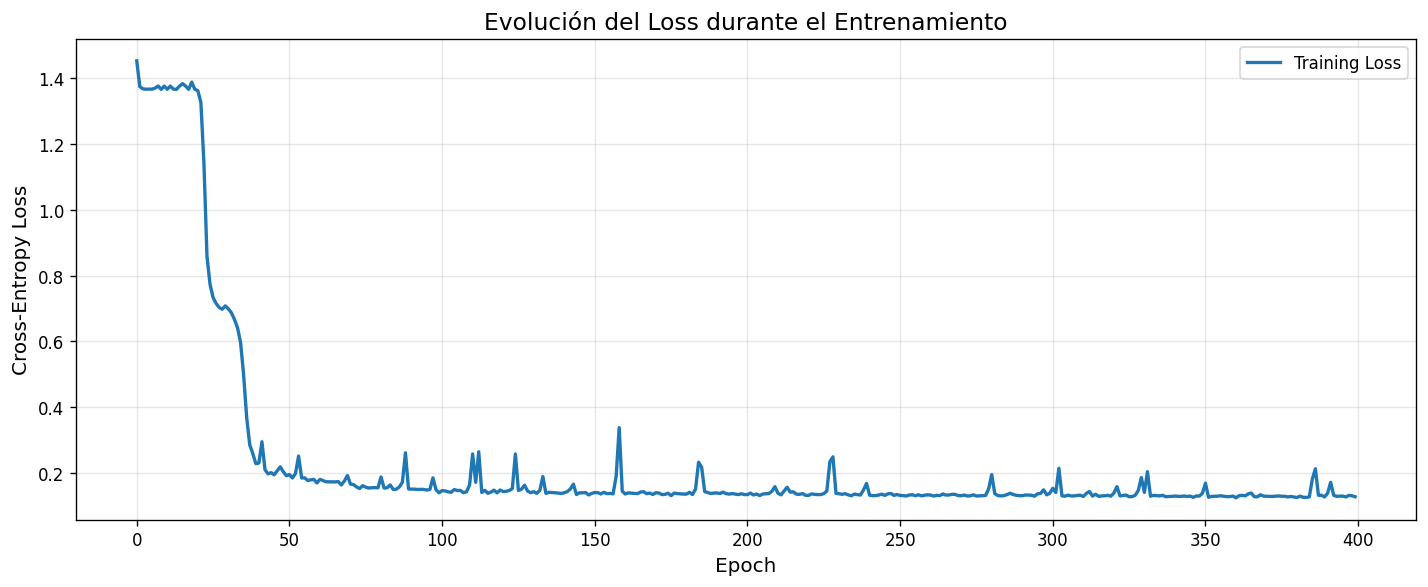

Loss inicial: 1.4536
Loss final: 0.1267
Reducción: 91.28%


In [48]:


# Graficar el loss durante el entrenamiento
plt.figure(figsize=(12, 5))
plt.plot(losses, linewidth=2, label='Training Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.title('Evolución del Loss durante el Entrenamiento', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Loss inicial: {losses[0]:.4f}")
print(f"Loss final: {losses[-1]:.4f}")
print(f"Reducción: {((losses[0] - losses[-1]) / losses[0] * 100):.2f}%")


## 2.2) INTEGRACIÓN DE LA RED NEURONAL CON A* (Inferencia en Vivo)

Ahora usamos la red neuronal entrenada para calcular **costos dinámicos** durante la búsqueda A*.

### Paso 1: Crear imagen de prueba con dos caminos
- **Camino A**: Corto pero pintado de AZUL (agua, costo alto = 9)
- **Camino B**: Largo pero pintado de GRIS (pavimento, costo bajo = 1)

El robot debe ser lo suficientemente inteligente para elegir el **Camino B** (largo pero rápido).

### Paso 2: Ejecutar A* con costos dinámicos
- Cada vez que A* evalúa un vecino, la red neuronal predice su costo
- A* automáticamente elige la ruta con menor costo total (no la más corta)

### Experimento esperado
- Sin red neuronal: A* elegiría el camino más corto (A)
- **Con red neuronal**: A* elige el camino más barato (B)

In [49]:
# Cargar imagen de prueba desde assets
IMAGE_PATH = os.path.join("assets", "turing.bmp")  
img = Image.open(IMAGE_PATH).convert("RGB")
img_array = np.array(img, dtype=np.uint8)

print(f"Imagen cargada: {IMAGE_PATH}")
print(f"Dimensiones: {img_array.shape}")

Imagen cargada: assets/turing.bmp
Dimensiones: (640, 640, 3)


In [50]:
# ── Ejecutar discretización ────────────────────────────────────────────────────
# TILE_SIZE=2 para capturar las curvas finas del laberinto turing
# (con tile=6 los tiles promedian pared+pasillo y se pierden las curvas)
TILE_SIZE = 2  # Tamaño de cada tile en píxeles

grid = discretize(img_array, tile_size=TILE_SIZE)
print(f"Grilla discretizada: {grid.shape[0]} filas × {grid.shape[1]} columnas  (tile_size={TILE_SIZE})")

for tile in grid:
    print(tile)

Grilla discretizada: 320 filas × 320 columnas  (tile_size=2)
[<CellType.FREE: 0> <CellType.FREE: 0> <CellType.WALL: 1>
 <CellType.WALL: 1> <CellType.WALL: 1> <CellType.FREE: 0>
 <CellType.FREE: 0> <CellType.FREE: 0> <CellType.FREE: 0>
 <CellType.FREE: 0> <CellType.FREE: 0> <CellType.FREE: 0>
 <CellType.FREE: 0> <CellType.WALL: 1> <CellType.WALL: 1>
 <CellType.WALL: 1> <CellType.WALL: 1> <CellType.WALL: 1>
 <CellType.WALL: 1> <CellType.WALL: 1> <CellType.WALL: 1>
 <CellType.FREE: 0> <CellType.FREE: 0> <CellType.FREE: 0>
 <CellType.FREE: 0> <CellType.FREE: 0> <CellType.FREE: 0>
 <CellType.WALL: 1> <CellType.WALL: 1> <CellType.WALL: 1>
 <CellType.WALL: 1> <CellType.WALL: 1> <CellType.FREE: 0>
 <CellType.FREE: 0> <CellType.FREE: 0> <CellType.FREE: 0>
 <CellType.FREE: 0> <CellType.FREE: 0> <CellType.FREE: 0>
 <CellType.FREE: 0> <CellType.FREE: 0> <CellType.FREE: 0>
 <CellType.WALL: 1> <CellType.WALL: 1> <CellType.WALL: 1>
 <CellType.WALL: 1> <CellType.WALL: 1> <CellType.FREE: 0>
 <CellType.

In [51]:
# ── Extraer posición de inicio y metas ──────────────────────────────────────
start_pos, goal_positions, n_walls = extract_key_positions(grid)

print(f"Posición de INICIO: {start_pos}")
print(f"Posiciones de META: {goal_positions}")
print(f"Número de paredes: {n_walls}")

  ⚠ 46 tiles START detectados → centroide en (219, 71)
Posición de INICIO: (219, 71)
Posiciones de META: [(124, 306), (124, 307), (124, 308), (124, 309), (124, 310), (125, 305), (125, 306), (125, 307), (125, 308), (125, 309), (125, 310), (125, 311), (126, 305), (126, 306), (126, 307), (126, 308), (126, 309), (126, 310), (126, 311), (126, 312), (127, 305), (127, 306), (127, 307), (127, 308), (127, 309), (127, 310), (127, 311), (127, 312), (128, 304), (128, 305), (128, 306), (128, 307), (128, 308), (128, 309), (128, 310), (128, 311), (128, 312), (129, 305), (129, 306), (129, 307), (129, 308), (129, 309), (129, 310), (129, 311), (129, 312), (130, 305), (130, 306), (130, 307), (130, 308), (130, 309), (130, 310), (130, 311), (131, 306), (131, 307), (131, 308), (131, 309), (131, 310), (183, 83), (183, 84), (183, 85), (183, 86), (183, 87), (184, 83), (184, 84), (184, 85), (184, 86), (184, 87), (184, 88), (185, 82), (185, 83), (185, 84), (185, 85), (185, 86), (185, 87), (185, 88), (185, 89), (

In [52]:
# ── Diccionario de costos (mapeo clase → costo de movimiento) ─────────────────
cost_dict = {
    0: 9,    # Blue (agua) = costo 9
    1: 2,    # Green (grama) = costo 2
    2: 1,    # Grey (pavimento) = costo 1
    3: 10,   # Pink (chicle) = costo 10
    4: 3     # Yellow (arena) = costo 3
}

print("Diccionario de costos (CORREGIDO):")
for class_idx, cost in cost_dict.items():
    print(f"  Clase {class_idx} ({lb.classes_[class_idx]}): costo {cost}")

# ── Crear instancia de MazeProblem con red neuronal ──────────────────────────
problem = MazeProblem(
    grid=grid,
    start=start_pos,
    goals=goal_positions,
    image=img_array,
    nn=nn,
    cost=cost_dict,
    tile_size=TILE_SIZE
)

print(f"\n✓ MazeProblem creado:")
print(f"  Grid: {problem.grid.shape}")
print(f"  Inicio: {problem.initial_state()}")
print(f"  Metas: {len(problem._goals)} posiciones")
print(f"  Red Neuronal: {'✓ Sí' if problem.nn is not None else 'No'}")
print(f"  Diccionario de costos: {problem.cost}")

Diccionario de costos (CORREGIDO):
  Clase 0 (Blue): costo 9
  Clase 1 (Green): costo 2
  Clase 2 (Grey): costo 1
  Clase 3 (Pink): costo 10
  Clase 4 (Yellow): costo 3

✓ MazeProblem creado:
  Grid: (320, 320)
  Inicio: (219, 71)
  Metas: 175 posiciones
  Red Neuronal: ✓ Sí
  Diccionario de costos: {0: 9, 1: 2, 2: 1, 3: 10, 4: 3}


In [53]:
# ── Ejecutar A* con costos dinámicos (red neuronal) ──────────────────────────
result = astar(problem, manhattan_heuristic)

print(f"\n=== RESULTADO DE A* CON COSTOS DINÁMICOS ===")
print(f"Ruta encontrada: {len(result.path)} pasos")
print(f"Costo total: {result.path_cost:.2f}")
print(f"Nodos explorados: {result.nodes_explored}")
print(f"Primeros 5 pasos: {result.path[:5]}")
print(f"Últimos 5 pasos: {result.path[-5:]}")


=== RESULTADO DE A* CON COSTOS DINÁMICOS ===
Ruta encontrada: 611 pasos
Costo total: 647.00
Nodos explorados: 4931
Primeros 5 pasos: [(219, 71), (219, 72), (219, 73), (219, 74), (219, 75)]
Últimos 5 pasos: [(128, 300), (128, 301), (128, 302), (128, 303), (128, 304)]


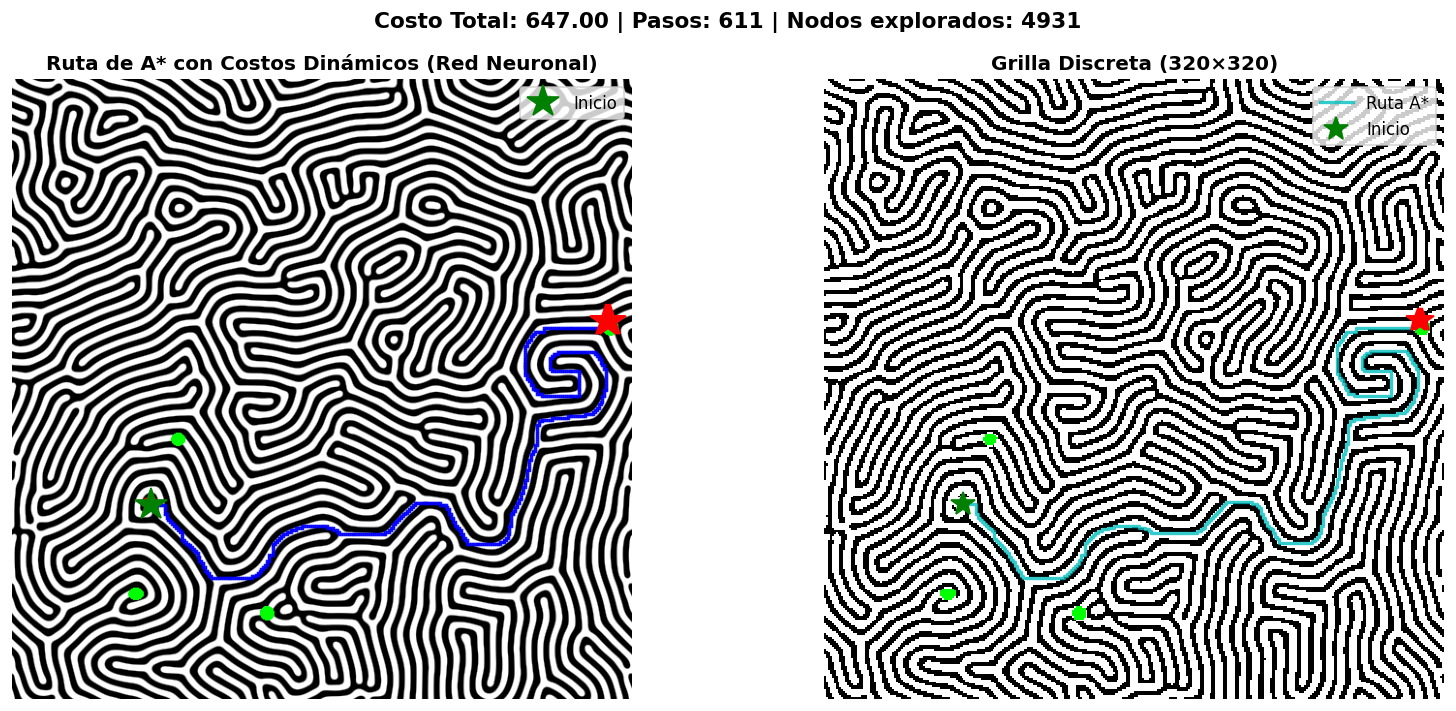


✓ Visualización completada:
  La ruta está trazada en AZUL/CYAN sobre la imagen
  Estrella VERDE = Inicio
  Estrellas ROJAS = Metas


In [54]:
# ── Visualizar la ruta en la imagen original ───────────────────────────────────

def grid_to_pixel(r: int, c: int, tile_size: int) -> tuple:
    """Convierte coordenada de grilla (row, col) al centro del tile en píxeles."""
    px = c * tile_size + tile_size / 2
    py = r * tile_size + tile_size / 2
    return px, py

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Imagen original con ruta superpuesta
axes[0].imshow(img_array)
axes[0].set_title("Ruta de A* con Costos Dinámicos (Red Neuronal)", fontsize=12, fontweight='bold')

# Dibujar la ruta en azul
for i in range(len(result.path) - 1):
    r1, c1 = result.path[i]
    r2, c2 = result.path[i + 1]
    px1, py1 = grid_to_pixel(r1, c1, TILE_SIZE)
    px2, py2 = grid_to_pixel(r2, c2, TILE_SIZE)
    axes[0].plot([px1, px2], [py1, py2], 'b-', linewidth=2, alpha=0.7)

# Marcar inicio y metas
start_px, start_py = grid_to_pixel(start_pos[0], start_pos[1], TILE_SIZE)
axes[0].plot(start_px, start_py, 'g*', markersize=20, label='Inicio')

for goal_r, goal_c in goal_positions[:3]:  # Mostrar primeras 3 metas
    goal_px, goal_py = grid_to_pixel(goal_r, goal_c, TILE_SIZE)
    axes[0].plot(goal_px, goal_py, 'r*', markersize=20)

axes[0].legend()
axes[0].axis('off')

# 2. Grilla discretizada con la ruta
axes[1].imshow(grid_to_rgb(grid), interpolation='nearest')
axes[1].set_title(f"Grilla Discreta ({grid.shape[0]}×{grid.shape[1]})", fontsize=12, fontweight='bold')

# Dibujar la ruta en la grilla
path_array = np.array(result.path)
axes[1].plot(path_array[:, 1], path_array[:, 0], 'c-', linewidth=2, alpha=0.8, label='Ruta A*')
axes[1].plot(start_pos[1], start_pos[0], 'g*', markersize=15, label='Inicio')

for goal_r, goal_c in goal_positions[:3]:
    axes[1].plot(goal_c, goal_r, 'r*', markersize=15)

axes[1].legend()
axes[1].axis('off')

plt.suptitle(f"Costo Total: {result.path_cost:.2f} | Pasos: {len(result.path)} | Nodos explorados: {result.nodes_explored}", 
             fontsize=13, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualización completada:")
print(f"  La ruta está trazada en AZUL/CYAN sobre la imagen")
print(f"  Estrella VERDE = Inicio")
print(f"  Estrellas ROJAS = Metas")



COMPARACIÓN: A* CON RED NEURONAL vs SIN RED NEURONAL

Métrica                        CON Red Neuronal     SIN Red Neuronal    
----------------------------------------------------------------------
Costo total                    647.00               610.00              
Número de pasos                611                  611                 
Nodos explorados               4931                 4910                
Costo por paso (promedio)      1.059                0.998               

----------------------------------------------------------------------
DIFERENCIA (NN - Sin NN):
  Costo:      +37.00 (+6.1%)
  Pasos:      +0 (+0.0%)


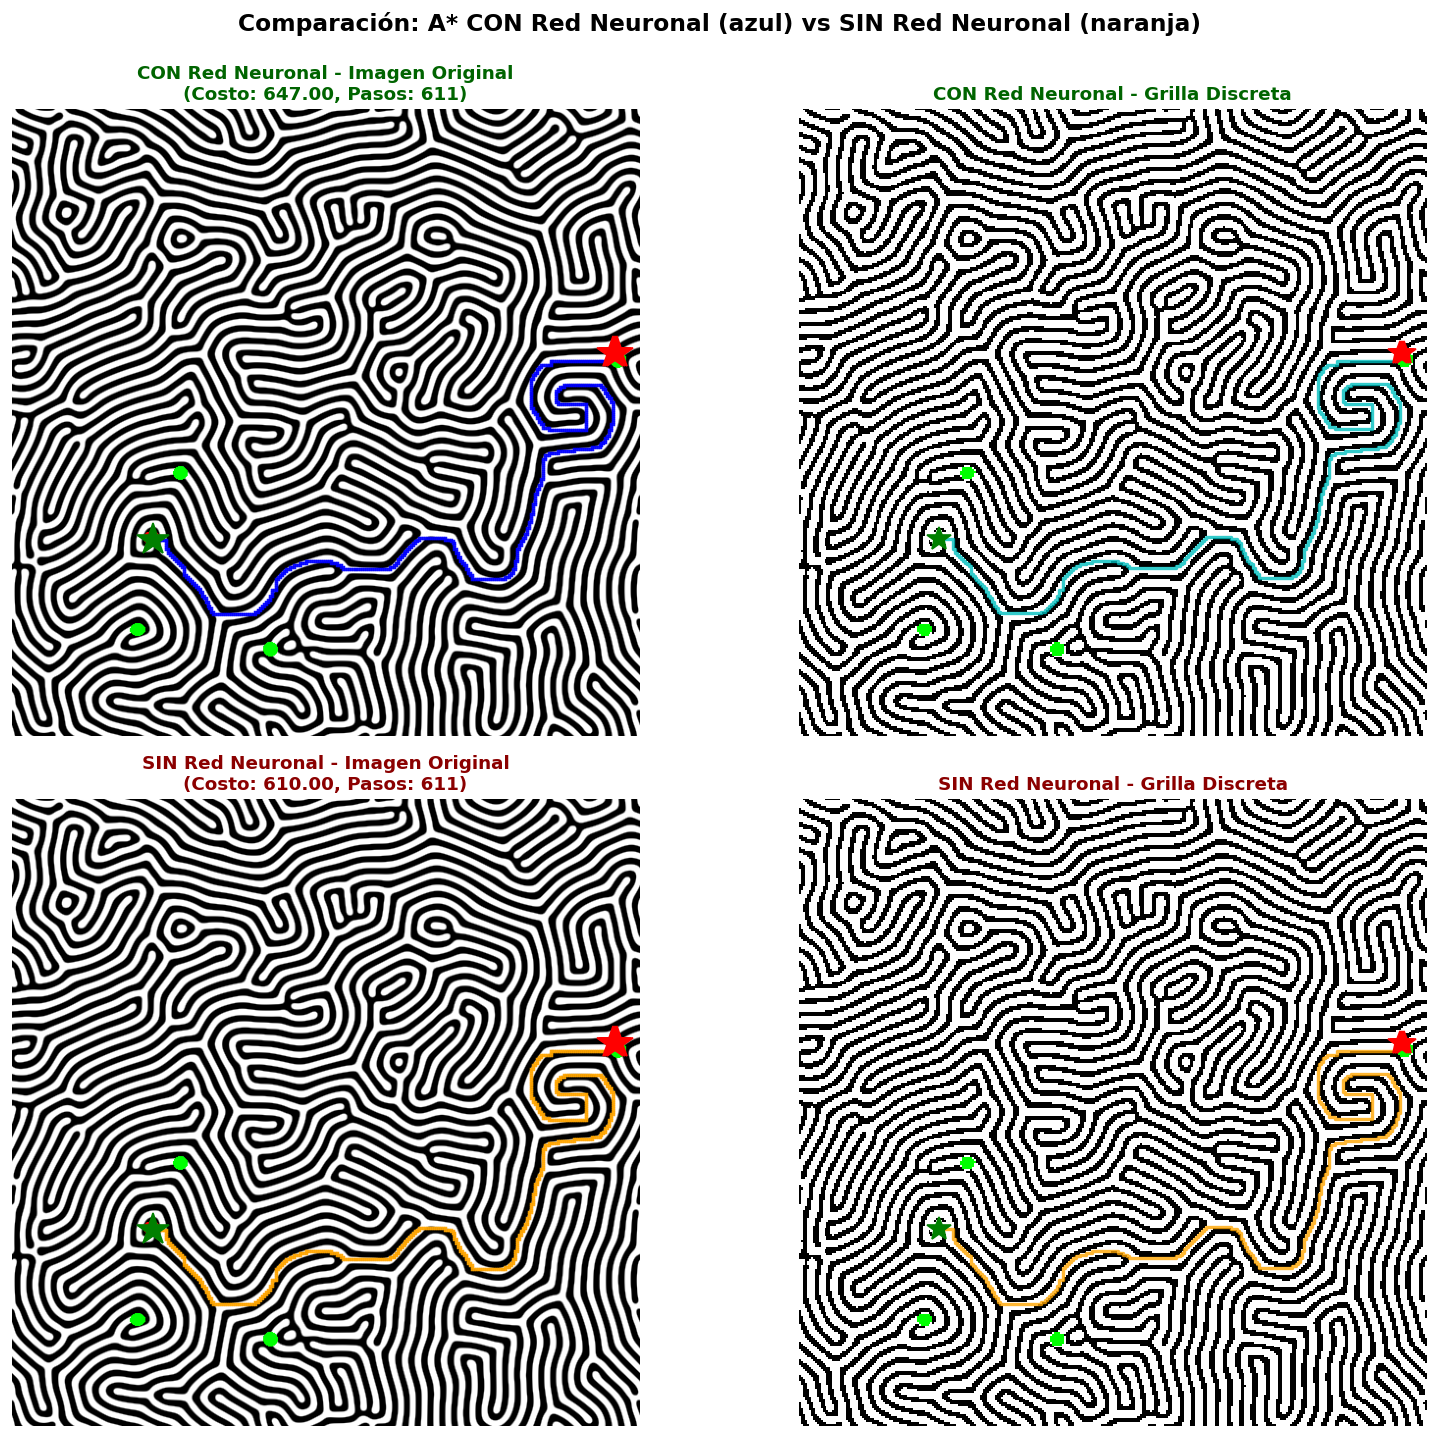


✓ Análisis completado:
  • CON NN: elige rutas considerando los costos dinámicos
  • SIN NN: elige la ruta más corta (todos los costos = 1.0)


In [55]:
# ── COMPARACIÓN: A* CON vs SIN Red Neuronal ────────────────────────────────────

# Crear problema SIN red neuronal (costos uniformes = 1.0)
problem_without_nn = MazeProblem(
    grid=grid,
    start=start_pos,
    goals=goal_positions,
    image=None,      # Sin imagen
    nn=None,         # Sin red neuronal
    cost=None,       # Sin diccionario de costos
    tile_size=TILE_SIZE
)

# Ejecutar A* SIN red neuronal
result_without_nn = astar(problem_without_nn, manhattan_heuristic)

# Comparar resultados
print("\n" + "="*70)
print("COMPARACIÓN: A* CON RED NEURONAL vs SIN RED NEURONAL")
print("="*70)
print(f"\n{'Métrica':<30} {'CON Red Neuronal':<20} {'SIN Red Neuronal':<20}")
print("-"*70)
print(f"{'Costo total':<30} {result.path_cost:<20.2f} {result_without_nn.path_cost:<20.2f}")
print(f"{'Número de pasos':<30} {len(result.path):<20} {len(result_without_nn.path):<20}")
print(f"{'Nodos explorados':<30} {result.nodes_explored:<20} {result_without_nn.nodes_explored:<20}")
print(f"{'Costo por paso (promedio)':<30} {result.path_cost/len(result.path):<20.3f} {result_without_nn.path_cost/len(result_without_nn.path):<20.3f}")

# Calcular diferencia
cost_diff = result.path_cost - result_without_nn.path_cost
steps_diff = len(result.path) - len(result_without_nn.path)

print("\n" + "-"*70)
print(f"DIFERENCIA (NN - Sin NN):")
print(f"  Costo:      {cost_diff:+.2f} ({(cost_diff/result_without_nn.path_cost*100):+.1f}%)")
print(f"  Pasos:      {steps_diff:+d} ({(steps_diff/len(result_without_nn.path)*100):+.1f}%)")
print("="*70)

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# --- CON Red Neuronal ---
# Imagen original
axes[0, 0].imshow(img_array)
axes[0, 0].set_title(f"CON Red Neuronal - Imagen Original\n(Costo: {result.path_cost:.2f}, Pasos: {len(result.path)})", 
                     fontsize=11, fontweight='bold', color='darkgreen')
for i in range(len(result.path) - 1):
    r1, c1 = result.path[i]
    r2, c2 = result.path[i + 1]
    px1, py1 = grid_to_pixel(r1, c1, TILE_SIZE)
    px2, py2 = grid_to_pixel(r2, c2, TILE_SIZE)
    axes[0, 0].plot([px1, px2], [py1, py2], 'b-', linewidth=2, alpha=0.7)
start_px, start_py = grid_to_pixel(start_pos[0], start_pos[1], TILE_SIZE)
axes[0, 0].plot(start_px, start_py, 'g*', markersize=20)
for goal_r, goal_c in goal_positions[:3]:
    goal_px, goal_py = grid_to_pixel(goal_r, goal_c, TILE_SIZE)
    axes[0, 0].plot(goal_px, goal_py, 'r*', markersize=20)
axes[0, 0].axis('off')

# Grilla con ruta
axes[0, 1].imshow(grid_to_rgb(grid), interpolation='nearest')
axes[0, 1].set_title(f"CON Red Neuronal - Grilla Discreta", fontsize=11, fontweight='bold', color='darkgreen')
path_array = np.array(result.path)
axes[0, 1].plot(path_array[:, 1], path_array[:, 0], 'c-', linewidth=2, alpha=0.8)
axes[0, 1].plot(start_pos[1], start_pos[0], 'g*', markersize=15)
for goal_r, goal_c in goal_positions[:3]:
    axes[0, 1].plot(goal_c, goal_r, 'r*', markersize=15)
axes[0, 1].axis('off')

# --- SIN Red Neuronal ---
# Imagen original
axes[1, 0].imshow(img_array)
axes[1, 0].set_title(f"SIN Red Neuronal - Imagen Original\n(Costo: {result_without_nn.path_cost:.2f}, Pasos: {len(result_without_nn.path)})", 
                     fontsize=11, fontweight='bold', color='darkred')
for i in range(len(result_without_nn.path) - 1):
    r1, c1 = result_without_nn.path[i]
    r2, c2 = result_without_nn.path[i + 1]
    px1, py1 = grid_to_pixel(r1, c1, TILE_SIZE)
    px2, py2 = grid_to_pixel(r2, c2, TILE_SIZE)
    axes[1, 0].plot([px1, px2], [py1, py2], 'orange', linewidth=2, alpha=0.7)
axes[1, 0].plot(start_px, start_py, 'g*', markersize=20)
for goal_r, goal_c in goal_positions[:3]:
    goal_px, goal_py = grid_to_pixel(goal_r, goal_c, TILE_SIZE)
    axes[1, 0].plot(goal_px, goal_py, 'r*', markersize=20)
axes[1, 0].axis('off')

# Grilla con ruta
axes[1, 1].imshow(grid_to_rgb(grid), interpolation='nearest')
axes[1, 1].set_title(f"SIN Red Neuronal - Grilla Discreta", fontsize=11, fontweight='bold', color='darkred')
path_array_no_nn = np.array(result_without_nn.path)
axes[1, 1].plot(path_array_no_nn[:, 1], path_array_no_nn[:, 0], 'orange', linewidth=2, alpha=0.8)
axes[1, 1].plot(start_pos[1], start_pos[0], 'g*', markersize=15)
for goal_r, goal_c in goal_positions[:3]:
    axes[1, 1].plot(goal_c, goal_r, 'r*', markersize=15)
axes[1, 1].axis('off')

plt.suptitle("Comparación: A* CON Red Neuronal (azul) vs SIN Red Neuronal (naranja)", 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Análisis completado:")
print(f"  • CON NN: elige rutas considerando los costos dinámicos")
print(f"  • SIN NN: elige la ruta más corta (todos los costos = 1.0)")
